## Simulador de Recorridos ciclistas

### Importamos librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from keras.models import load_model
import pickle
import time

import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn')

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Como tenemos procesado todo en el mismo fichero, lo cargamos

path = '../Entrenamientos/Procesado_Tramos.xlsx'
df = pd.read_excel(path)

### Filtramos datos

In [3]:
#Eliminar las filas que no tienen datos y seleccionamos la prueba que queremos simular
df = df[df["porc"]!=np.inf]
df = df[df["prueba"]=="20180429_LEMG_195_90_R_C.gpx"]

In [4]:
df.describe()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum
count,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,60.500000,3496.016393,3547.770492,207.940679,94.262295,726.590164,35.150620,-1.333628,0.058167,49403.237132
std,35.362409,1946.877241,1937.072375,52.063138,172.804471,1130.014691,12.474903,13.483191,2.092644,27074.087892
min,0.000000,0.000000,16.000000,22.992004,1.000000,9.697469,12.922105,-14.992324,-6.597866,173.532309
25%,30.250000,2196.750000,2230.750000,180.272469,7.000000,61.750000,26.661969,-14.375875,-0.870941,30967.492612
50%,60.500000,3286.500000,3353.500000,223.516007,50.500000,466.777042,33.203336,-6.759451,0.003106,47158.500000
75%,90.750000,5248.500000,5283.500000,241.060519,92.750000,847.570583,41.207362,14.235446,0.859900,72401.000000
max,121.000000,6300.000000,6314.000000,299.800000,1158.000000,8788.000000,75.302316,14.918299,7.046886,88630.000000


In [5]:
#Se revisa que no existan datos anómalos
df.head()

,tramo,tramo_inicial,tramo_final,pwr,time_seg,dist,spd,viento_aparente,porc,dist_acum,prueba
0,0,0,16,196.808012,17,187.41664,39.688230,14.918299,-0.399565,173.532309,20180429_LEMG_195_90_R_C.gpx
1,1,16,75,230.996299,98,886.58336,32.568368,14.577416,0.523132,1055.000000,20180429_LEMG_195_90_R_C.gpx
2,2,75,122,194.043315,60,616.40000,36.984000,14.550887,-0.240187,1677.304307,20180429_LEMG_195_90_R_C.gpx
3,3,122,227,221.693546,193,1692.60000,31.571813,14.552940,0.895103,3364.000000,20180429_LEMG_195_90_R_C.gpx
4,4,227,273,169.324586,47,538.40000,41.239149,14.433466,-1.235191,3911.000000,20180429_LEMG_195_90_R_C.gpx


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  1.,  1.,
         0.,  3.,  0.,  0.,  1.,  0.,  2.,  1.,  3.,  1.,  0.,  1.,  4.,
         3.,  2.,  1.,  1.,  3.,  1.,  3.,  3., 11., 18.,  8.,  1.,  3.,
         3.,  3.,  4.,  1.,  2.,  1.,  2.,  1.,  0.,  1.,  1.,  2.,  1.,
         1.,  1.,  1.,  1.,  2.,  3.,  2.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-6.59786614, -6.46141862, -6.32497111, -6.18852359, -6.05207607,
        -5.91562855, -5.77918103, -5.64273351, -5.50628599, -5.36983847,
        -5.23339095, -5.09694343, -4.96049591, -4.82404839, -4.68760087,
        -4.55115335, -4.41470584, -4.27825832, -4.1418108 , -4.00536328,
        -3.86891576, -3.73246824, -3.59602072, -3.4595732 , -3.32312568,
        -3.18667816, -3.05023064, -2.91378312, -2.7773356 , -2.640888

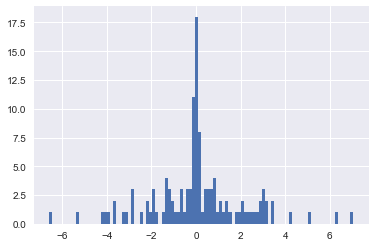

In [6]:
plt.hist(df['porc'],bins=100)

Vemos que la mayoría de tramos están centrados en porcentajes cercanos a 0, aunque también hay varios tramos de subidas y bajadas

In [34]:
#Prueba iterando en cada tramo con intervalos aleatorios con el modelo desarrollado CON TENSORFLOW (PRIMERA PASADA)

#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 50
pot_max = 300
ff_1 = 0.1
ff_2 = 0.5

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        #prueba estandar: 10672.96875
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-1*(abs(viento)+1), abs(viento)+1)
        #prueba viento a favor le damos chicha
        #10632.642578125
        
        if viento<0:
            min_random = viento-1
            max_random = abs(viento**2)+1
        else:
            max_random = viento+1
            min_random = -1*viento**2-1
            
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)

        if potencia_aux > pot_max:
            potencia = pot_max
        elif potencia_aux < pot_min:
            potencia = pot_min
        else:
            potencia = potencia_aux
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

Empezamos la prueba 0
--- 1.3736093044281006 seconds ---
Intento 0 con potencia media 251
Intento 1 con potencia media 257
Intento 2 con potencia media 251
Intento 3 con potencia media 244
Intento 4 con potencia media 246
Intento 5 con potencia media 256
Intento 6 con potencia media 254
Intento 7 con potencia media 250
Intento 8 con potencia media 252
Intento 9 con potencia media 251
Empezamos la prueba 10
--- 2.8317620754241943 seconds ---
Intento 10 con potencia media 263
Intento 11 con potencia media 246
Intento 12 con potencia media 251
Intento 13 con potencia media 246
Intento 14 con potencia media 241
Intento 15 con potencia media 255
Intento 16 con potencia media 238
Intento 17 con potencia media 242
Intento 18 con potencia media 251
Intento 19 con potencia media 250
Empezamos la prueba 20
--- 4.164777994155884 seconds ---
Intento 20 con potencia media 256
Intento 21 con potencia media 252
Intento 22 con potencia media 248
Intento 23 con potencia media 253
Intento 24 con potenci

Intento 204 con potencia media 254
Intento 205 con potencia media 248
Intento 206 con potencia media 240
Intento 207 con potencia media 247
Intento 208 con potencia media 228
Intento 209 con potencia media 250
Empezamos la prueba 210
--- 29.874823808670044 seconds ---
Intento 210 con potencia media 246
Intento 211 con potencia media 245
Intento 212 con potencia media 248
Intento 213 con potencia media 248
Intento 214 con potencia media 253
Intento 215 con potencia media 250
Intento 216 con potencia media 246
Intento 217 con potencia media 250
Intento 218 con potencia media 239
Intento 219 con potencia media 244
Empezamos la prueba 220
--- 31.273556232452393 seconds ---
Intento 220 con potencia media 243
Intento 221 con potencia media 260
Intento 222 con potencia media 241
Intento 223 con potencia media 253
Intento 224 con potencia media 246
Intento 225 con potencia media 231
Intento 226 con potencia media 244
Intento 227 con potencia media 254
Intento 228 con potencia media 253
Intento

Intento 406 con potencia media 242
Intento 407 con potencia media 240
Intento 408 con potencia media 248
Intento 409 con potencia media 248
Empezamos la prueba 410
--- 58.270432472229004 seconds ---
Intento 410 con potencia media 250
Intento 411 con potencia media 253
Intento 412 con potencia media 246
Intento 413 con potencia media 243
Intento 414 con potencia media 248
Intento 415 con potencia media 254
Intento 416 con potencia media 259
Intento 417 con potencia media 254
Intento 418 con potencia media 237
Intento 419 con potencia media 257
Empezamos la prueba 420
--- 59.71350717544556 seconds ---
Intento 420 con potencia media 251
Intento 421 con potencia media 244
Intento 422 con potencia media 253
Intento 423 con potencia media 245
Intento 424 con potencia media 251
Intento 425 con potencia media 259
Intento 426 con potencia media 244
Intento 427 con potencia media 250
Intento 428 con potencia media 238
Intento 429 con potencia media 252
Empezamos la prueba 430
--- 61.165333509445

Intento 608 con potencia media 233
Intento 609 con potencia media 242
Empezamos la prueba 610
--- 86.01304769515991 seconds ---
Intento 610 con potencia media 246
Intento 611 con potencia media 253
Intento 612 con potencia media 253
Intento 613 con potencia media 244
Intento 614 con potencia media 240
Intento 615 con potencia media 251
Intento 616 con potencia media 256
Intento 617 con potencia media 248
Intento 618 con potencia media 236
---Total time: 87.19549298286438 seconds ---
Casos descartados: 569
Casos favorables: 50


In [35]:
#Creamos DataFrame y renombramos las columnas
ds = pd.DataFrame(resultados)
ds.columns = ('intento','pwr','secs','list')
ds

,intento,pwr,secs,list
0,16,238.590424,11189.244141,"[[0, 234.79382548469334, 37.02924, 187.41664, ..."
1,24,239.144821,11552.812500,"[[0, 271.79382548469334, 34.56214, 187.41664, ..."
2,36,239.469391,11237.051758,"[[0, 267.79382548469334, 34.816525, 187.41664,..."
3,71,235.357925,11181.182617,"[[0, 214.79382548469334, 38.380905, 187.41664,..."
4,79,236.457031,11740.614258,"[[0, 300, 32.828224, 187.41664, 20.552433, -0...."
5,91,236.629395,11298.553711,"[[0, 233.79382548469334, 37.096825, 187.41664,..."
6,111,232.196518,11830.843750,"[[0, 273.79382548469334, 34.434944, 187.41664,..."
7,112,239.796066,11365.759766,"[[0, 187.79382548469334, 37.567654, 187.41664,..."
8,133,233.705322,11688.897461,"[[0, 300, 32.828224, 187.41664, 20.552433, -0...."
9,158,236.540314,11240.509766,"[[0, 225.79382548469334, 37.63749, 187.41664, ..."


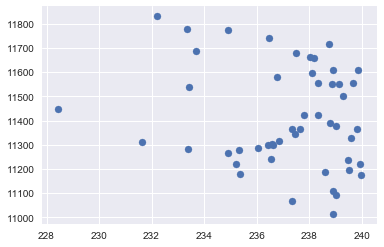

In [36]:
plt.scatter(ds['pwr'],ds['secs'])

En el scatter ya se ve con la misma potencia media tenemos distintos tiempos de finalización y viceversa

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 3., 1., 0., 0., 0., 0., 0., 2., 2., 1., 0., 0., 1.,
        2., 3., 2., 0., 2., 3., 1., 2., 3., 1., 2., 6., 2., 2., 2., 4.]),
 array([228.42074585, 228.65195984, 228.88317383, 229.11438782,
        229.34560181, 229.5768158 , 229.80802979, 230.03924377,
        230.27045776, 230.50167175, 230.73288574, 230.96409973,
        231.19531372, 231.42652771, 231.6577417 , 231.88895569,
        232.12016968, 232.35138367, 232.58259766, 232.81381165,
        233.04502563, 233.27623962, 233.50745361, 233.7386676 ,
        233.96988159, 234.20109558, 234.43230957, 234.66352356,
        234.89473755, 235.12595154, 235.35716553, 235.58837952,
        235.81959351, 236.0508075 , 236.28202148, 236.51323547,
        236.74444946, 236.97566345, 237.20687744, 237.43809143,
        237.66930542, 237.90051941, 238.1317334 , 238.36294739,
        238.59416138, 238.82537537, 239.05658936, 239.28780334,
      

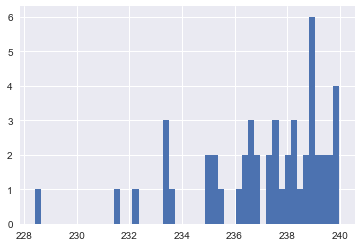

In [37]:
plt.hist(ds['pwr'],bins=50)

Histograma de potencias validas para la simulación

In [39]:
#Pintamos el mejor resultado
a = ds.groupby(['intento'])['secs'].agg('sum').sort_values(ascending=True)
a[:1].max()

11014.2451171875

In [40]:
#Nos quedamos con los 50 mejores resultados para ser analizdos en Tableau
ganadores = pd.DataFrame(ds[ds['secs']<=a[:50].max()][['intento','list']])
ganadores

,intento,list
0,16,"[[0, 234.79382548469334, 37.02924, 187.41664, ..."
1,24,"[[0, 271.79382548469334, 34.56214, 187.41664, ..."
2,36,"[[0, 267.79382548469334, 34.816525, 187.41664,..."
3,71,"[[0, 214.79382548469334, 38.380905, 187.41664,..."
4,79,"[[0, 300, 32.828224, 187.41664, 20.552433, -0...."
5,91,"[[0, 233.79382548469334, 37.096825, 187.41664,..."
6,111,"[[0, 273.79382548469334, 34.434944, 187.41664,..."
7,112,"[[0, 187.79382548469334, 37.567654, 187.41664,..."
8,133,"[[0, 300, 32.828224, 187.41664, 20.552433, -0...."
9,158,"[[0, 225.79382548469334, 37.63749, 187.41664, ..."


In [41]:
#Agregamos las características de cada tramo al df de ganadores y sacamos el resultado a Excel
for i in range(len(ganadores)):
    if i == 0:
        df_ganador = pd.DataFrame(ganadores.values[i][1])
        df_ganador.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_ganador['Intento'] = ganadores.values[i][0]
    else:
        df_aux = pd.DataFrame(ganadores.values[i][1])
        df_aux.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
        df_aux['Intento'] = ganadores.values[i][0]
        df_ganador = df_ganador.append([df_aux])
        del df_aux
df_ganador.to_excel('res_sim.xlsx')
df_ganador.head()

,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,234.793825,37.029240,187.41664,18.220734,-0.399565,14.918299,16
1,1,300.000000,31.562040,886.58336,101.124641,0.523132,14.577416,16
2,2,264.666547,34.760178,616.40000,63.838570,-0.240187,14.550887,16
3,3,300.000000,31.059664,1692.60000,196.182419,0.895103,14.552940,16
4,4,222.891031,38.866608,538.40000,49.869030,-1.235191,14.433466,16


In [43]:
#Juntamos el resultado de la simulación con el recorrido original a efectos de comparativa posterior en Tableau
df_input = df[['tramo','pwr','spd','dist','time_seg','porc','viento_aparente']]
df_input.columns =[["Tramos","Potencia","Velocidad","Distancia","Tiempo","Pendiente","Viento"]]
df_input['Intento'] = 'Original'
df_input.append([df_ganador]).to_excel('res_sim_ori.xlsx')
df_input.head()

C:\Users\eduardo.hernanz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Tramos,Potencia,Velocidad,Distancia,Tiempo,Pendiente,Viento,Intento
0,0,196.808012,39.688230,187.41664,17,-0.399565,14.918299,Original
1,1,230.996299,32.568368,886.58336,98,0.523132,14.577416,Original
2,2,194.043315,36.984000,616.40000,60,-0.240187,14.550887,Original
3,3,221.693546,31.571813,1692.60000,193,0.895103,14.552940,Original
4,4,169.324586,41.239149,538.40000,47,-1.235191,14.433466,Original


#### Posible mejora del modelo, inicializando la potencia de cada tramo con el mejor resultado de la primera simulación

In [ ]:
#CON TENSORFLOW (SEGUNDA PASADA)
#Almacenamos la hora de inicio para evaluar el tiempo que tarda en ejecutar
start_time = time.time()

#Cargamos los dos modelos con los que vamos a trabajar
model_TF = load_model('../RNN/TF_Tramos_2.model')
model_Scalar = pickle.load(open("../RNN/Scaler.model", "rb"))

#Inicializamos las variables de control del flujo de ejecución
resultados = []

fail = 0 #Contador de simulaciones fallidas
exito = 0 #Contador de simulaciones correctas
num_pruebas = 50 #Número de éxitos para finalizar la simulación
fi = 0 #Variable para iterar

#Las siguientes variables se rellenan a criterio del entrenador o de quien use esta simulación
potencia_objetivo = 220
pot_min = 50
pot_max = 300
ff_1 = 0.1
ff_2 = 0.5

#Repetimos la simulación de pruebas hasta que tenemos un número de exitos concreto
while exito < num_pruebas:
    if (fi % 10) == 0:
        print('Empezamos la prueba %d' %fi)
        print("--- %s seconds ---" % (time.time() - start_time))
    
    #Reiniciamos la variables para acumular cada prueba
    potencia_acum = 0
    tiempo_acum = 0
    i= 0
    lista_tramo_potencia = []
    
    #Simulamos cada tramo de la prueba
    while i < len(df):
        
        #Recuperamos el porcentaje de la pendiente, el viento y la distancia
        porc = df[i:i+1]["porc"].iloc[0]
        viento = df[i:i+1]["viento_aparente"].iloc[0]
        distancia = df[i:i+1]["dist"].iloc[0]
        
        #Asignamos la potencia inicial según la sigmoide que se puede consultar en ../Machine Learning/Warm-Start.ipynb
        #Adicionalmente introducimos un factor de variabilidad basado en el viento aparente (>0 si viento en contra y viceversa)           
        #prueba estandar: 10672.96875
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-1*(abs(viento)+1), abs(viento)+1)
        #prueba viento a favor le damos chicha
        #10632.642578125
        
        if viento<0:
            min_random = viento-1
            max_random = abs(viento**2)+1
        else:
            max_random = viento+1
            min_random = -1*viento**2-1
            
        #potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))*(np.random.randint(min_random,max_random)+100)/100
        potencia_aux = pot_min+(pot_max-pot_min)/(1+ff_1*np.e**(ff_2*porc*-1))+np.random.randint(-100,100)

        if potencia_aux > pot_max:
            potencia = pot_max
        elif potencia_aux < pot_min:
            potencia = pot_min
        else:
            potencia = potencia_aux
        
        #Utilizamos el modelo de normalización entrenado para ajustar los datos de entrada
        input_model = model_Scalar.transform([[potencia, porc, viento]])
        
        #Utilizamos el modelo de Tensor Flow para predecir la velocidad media de ese tramo
        velocidad = model_TF.predict(input_model)[0]
        
        #Con la velocidad del paso anterior y la distancia del tramo, calculamos el tiempo necesario para recorrerlo
        nuevo_tiempo = distancia/(velocidad/3.6)
        #Almacenamos la información del paso actual
        lista_tramo_potencia.append([i, potencia,velocidad[0],distancia,nuevo_tiempo[0],porc,viento])
        
        #Acumulamos la potencia y el tiempo para evaluar el resultado final y determinar si es éxito o no, y con que tiempo total
        potencia_acum = potencia_acum + (potencia * nuevo_tiempo)
        tiempo_acum = tiempo_acum + nuevo_tiempo
        
        i += 1
    
    potencia_media = potencia_acum/tiempo_acum
    print("Intento %d con potencia media %d" %(fi, potencia_media))
    
    #Si la potencia queda fuera de intervalos viables, no se considera como exito
    #Nos quedamos con +/-20w sobre la potencia objetivo para luego seleccionar las mejores distribuciones de potencia
    if (potencia_media > potencia_objetivo-20) and (potencia_media < potencia_objetivo+20):
        #print(potencia_media, tiempo_acum)
        resultados.append([fi,potencia_media[0], tiempo_acum[0], lista_tramo_potencia])
        exito +=1
    else:
        #Contamos las simulaciones consideradas sin exito
        fail +=1
    
    fi +=1

print("---Total time: %s seconds ---" % (time.time() - start_time))

print('Casos descartados: %d' %fail)
print('Casos favorables: %d' %(len(resultados)))

In [ ]:
        potencia = potencias_medias[i]+np.random.randint(-10, 10)